In [29]:
def plot_templates(W):
    W = W.astype(int)
    for i in range(10):
        plt.figure(i)
        img = W[i].reshape([28,28])
        plt.gray()
        plt.imshow(img)

In [30]:
def normalize(img):
    mu = np.mean(img)
    std = np.std(img)
    img = (img - mu)//std
    return img

In [31]:
import torch, torchvision
from torchvision import datasets, transforms
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=None)

The Accuracy is 77.19% on test data


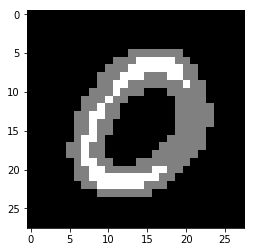

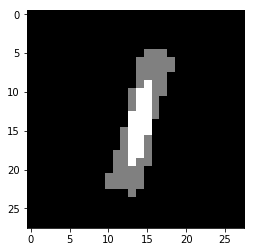

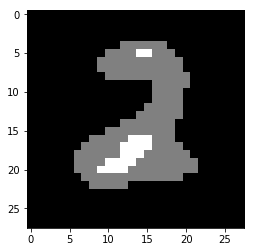

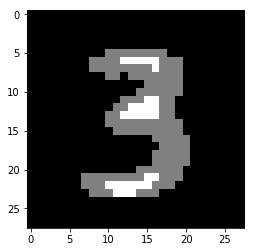

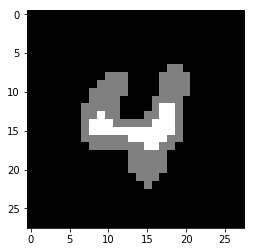

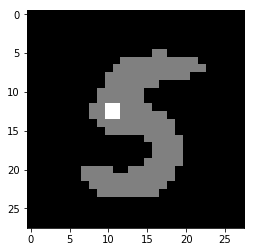

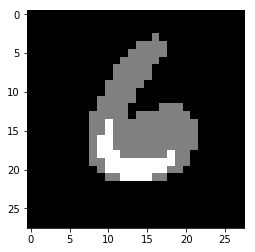

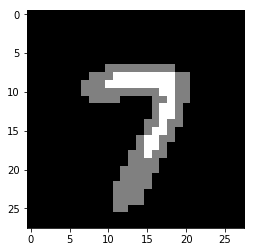

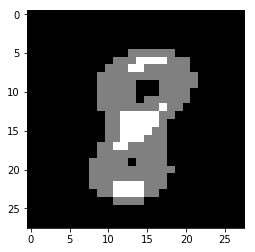

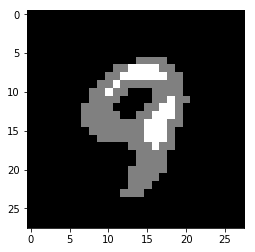

In [32]:
########## 4-a ###########
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST

## Load Data
svpath = 'data/mnist/MNIST/raw/'
mndata = MNIST(svpath)

images, labels = mndata.load_training()
images_t, labels_t = mndata.load_testing()

images = normalize(np.array(images)) # 60000x784
images_t = normalize(np.array(images_t)) # 10000x784

dic = {}
count = {}
W = np.zeros((10,784))
## Create Weight Matrix
for i in range(len(images)):
    l = labels[i]
    if l not in dic:
        dic[l] = images[i]
        count[l] = 1
    else:
        dic[l] += images[i]
        count[l] += 1
for i in range(10):
    dic[i] //= count[i]
    W[i] = dic[i]

plot_templates(W)
    
scores = W.dot(images_t.T) #10x10000
y_hat = scores.argmax(axis=0)
accuracy = np.sum(y_hat == np.array(labels_t)) / len(labels_t)*100
print("The Accuracy is " + str(accuracy) + "% on test data")

In [86]:
def HOG(img):
    ## Calculate gradient in x,y directions
    sx = ndimage.sobel(img, axis=0, mode='constant')
    sy = ndimage.sobel(img, axis=1, mode='constant')
    
    ## Calculate magnitude and angle based on sx,sy
    sob = np.hypot(sx, sy)
    angle = np.arctan2(sy,sx) * 180 / np.pi
    angle[angle<0] += 180  ## Shift all negative degree to positive

    ## Initialization
    bin_num = 6  ## bin number plus 1 to fit linspace function
    bins = np.linspace(0, 180, bin_num)
    patch = np.zeros((4,4))

    w = np.zeros((49,5))
    for i in range(7):
        for j in range(7):
            ## Extracting patch of size 4x4
            patch_b = np.zeros((5,1))
            mag = sob[i*4:i*4+4, j*4:j*4+4]
            ang = angle[i*4:i*4+4, j*4:j*4+4]
            mag = np.ravel(mag)
            ang = np.ravel(ang)
            
            ## Find corresponding magnitude for each pixel
            ## based on which bin its angle belongs to
            for k in range(len(mag)):
                temp = np.histogram( ang[k],bins )[0]
                idx = temp.argmax(axis=0)  # idx in the bin
                p1 = (ang[k]-idx*36)/36  # percentage belong to cur bin
                p2 = 1 - p1              # percentage belong to next bin
                patch_b[idx] += mag[k]*p1 # magnitude * p(left_bin)
                
                # magnitude * p(right_bin). Last bin merge with the 1st
                if idx == 4:
                    patch_b[0] += mag[k]*p2
                else:
                    patch_b[idx+1] += mag[k]*p2
                break
            idx = i*7+j
            w[idx] = patch_b.T
    return np.ravel(w)

In [87]:
######### 4-b ##########
import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST
from scipy import ndimage

svpath = 'data/mnist/MNIST/raw/'
mndata = MNIST(svpath)

images, labels = mndata.load_training()
images_t, labels_t = mndata.load_testing()

images = normalize(np.array(images)) # 60000x784
images_t = normalize(np.array(images_t)) # 10000x784

dic = {}
count = {}
W = np.zeros((10,245))

## Extracing features from training images
for i in range(len(images)):
    l = labels[i]
    img = images[i].reshape([28,28])

    w = HOG(img)
    if l not in dic:
        dic[l] = w
        count[l] = 1
    else:
        dic[l] += w
        count[l] += 1
for i in range(10):
    dic[i] //= count[i]
    W[i] = dic[i]

In [88]:
########### 4-b Cont. ###########
## Extracing features from testing images
pre_Test = np.zeros((245,10000))
for i in range(len(images_t)):
    img = images_t[i].reshape([28,28])
    w = HOG(img)
    pre_Test[:,i] = w

In [90]:
########### 4-b Accuracy ############
## Matrix multiplication between train and test images features
scores = W.dot(pre_Test) #10x10000
y_hat = scores.argmax(axis=0)
accuracy = np.sum(y_hat == np.array(labels_t)) / len(labels_t)*100
print("The accuracy is "+ str(accuracy)+"%. \
It performs worse than (a) by 20%. The reason could be the performance\
of HoG, which has hyperparameters like bin_num and patch size to adjust.")

The accuracy is 58.089999999999996%. It performs worse than (a) by 20%. The reason could be the performanceof HoG, which has hyperparameters like bin_num and patch size to adjust.


In [96]:
######## 4-c ##########
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

images_t = np.zeros((784,10))
labels_t = np.array([0,1,2,3,4,5,6,7,8,9])
for i in range(10):
    name = str(i)+'.jpg'
    im_gray = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    small = cv2.resize(im_gray, (28,28))
    small = np.ravel(small)
    images_t[:,i] = small

########### 4-c Cont. ###########
pre_Test = np.zeros((245,10))
for i in range(len(images_t[0])):
    img = images_t[:,i].reshape([28,28])
    w = HOG(img)
    pre_Test[:,i] = w
########### 4-c Accuracy ############
scores = W.dot(pre_Test) #10x10000
y_hat = scores.argmax(axis=0)
accuracy = np.sum(y_hat == np.array(labels_t)) / len(labels_t)*100
print("The predictions are "+str(y_hat)+ ". \
The accuracy is "+ str(accuracy)+"%.")
print("It works poorly with very low accuracy score, with most of the predictions\
being 8. The reason could be (A) the HoG accuracy isn't very high in the \
first place, and (B) hand-written images are very different from the set \
training data is coming from, therefore the testing data's accuracy could \
have been an overestimation, and this hand-written test is potentially \
a more realistic examination of the classifier's performance.")

The predictions are [0 8 9 8 8 0 8 9 8 8]. The accuracy is 20.0%.
It works poorly with very low accuracy score, with most of the predictionsbeing 8. The reason could be (A) the HoG accuracy isn't very high in the first place, and (B) hand-written images are very different from the set training data is coming from, therefore the testing data's accuracy could have been an overestimation, and this hand-written test is potentially a more realistic examination of the classifier's performance.
